## Projet PACTE 4A-IIIA: Data Science Formula 1 World  Championship
### Sujet: L'impact de la position de depart sur le resultat d'une course.

Dans cette étude, nous nous intéressons à l’impact de la position de départ sur le résultat d’une course de Formule 1, en adoptant une approche basée sur l’analyse descriptive des données. L’objectif est de comprendre comment la position de départ influence les performances des pilotes, tout en explorant des facteurs connexes tels que les classements cumulés et les performances individuelles.

Pour cette analyse, nous utilisons plusieurs fichiers issus de la base de données Formula 1, chacun apportant des informations complémentaires :  

- **`races.csv`** : Offre des informations contextuelles sur chaque Grand Prix, telles que l’année, le lieu, et le circuit.  
- **`results.csv`** : Détaille les résultats spécifiques de chaque course, comme la position finale, les points marqués et les incidents de course.  


Les variables pertinentes que nous analyserons incluent :  
1. **`grid`** (fichier `results.csv`) : Position de départ sur la grille, essentielle pour comprendre son influence sur les performances en course.  
2. **`positionOrder`** (fichier `results.csv`) : Position finale à l’arrivée, pour évaluer les progrès ou les déclins des pilotes pendant la course.  

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#### 1. Chargement des données

In [5]:
races = pd.read_csv("./dataset/races.csv")
results = pd.read_csv("./dataset/results.csv")


##### Verification de chargement

In [6]:
# Vérification des datasets importés
datasets = {
    
    "races": races,
    "results": results,
   
}

for name, df in datasets.items():
    print(f"{name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")

races: 1125 lignes, 18 colonnes
results: 26519 lignes, 18 colonnes


#### 2. Préparation des données

#### 2.1. Exploration initiale des données
Cette étape permet d’avoir une vue d’ensemble des datasets (colonnes, types de données, valeurs manquantes).

In [7]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [8]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


##### 2.2. Selection des variables d'études

In [9]:
# Filtrer les années de course entre 2017 et 2023
races_filtered = races[(races['year'] >= 2018) & (races['year'] <= 2023)]

# Merge des deux datasets pour relier les résultats aux informations de course, y compris les rounds
merged_data = pd.merge(results, races_filtered, on='raceId')

# Extraire les colonnes nécessaires
data_filtered = merged_data[['year', 'round', 'grid', 'positionOrder']]

In [10]:
data_filtered.size

10000

In [11]:
data_filtered.dtypes

year             int64
round            int64
grid             int64
positionOrder    int64
dtype: object

In [12]:
data_filtered.head()

,year,round,grid,positionOrder
0,2018,1,3,1
1,2018,1,1,2
2,2018,1,2,3
3,2018,1,8,4
4,2018,1,10,5


##### 2.3. Traitement des valeurs manquantes
Les valeurs manquantes peuvent fausser les résultats. On identifie ces valeurs et choisit une stratégie : suppression, imputation, ou autre.

In [13]:
# Supprimer les lignes avec des valeurs nulles dans grid ou positionOrder
data_filtered = data_filtered.dropna(subset=['grid', 'positionOrder'])
data_filtered.size

10000

### 3. Analyse Exploratoire des Données

#### 3.1. Graphique de corrélation (une année donnée)
Corrélation entre la position de départ et la position finale pour l'année 2020 (par round)

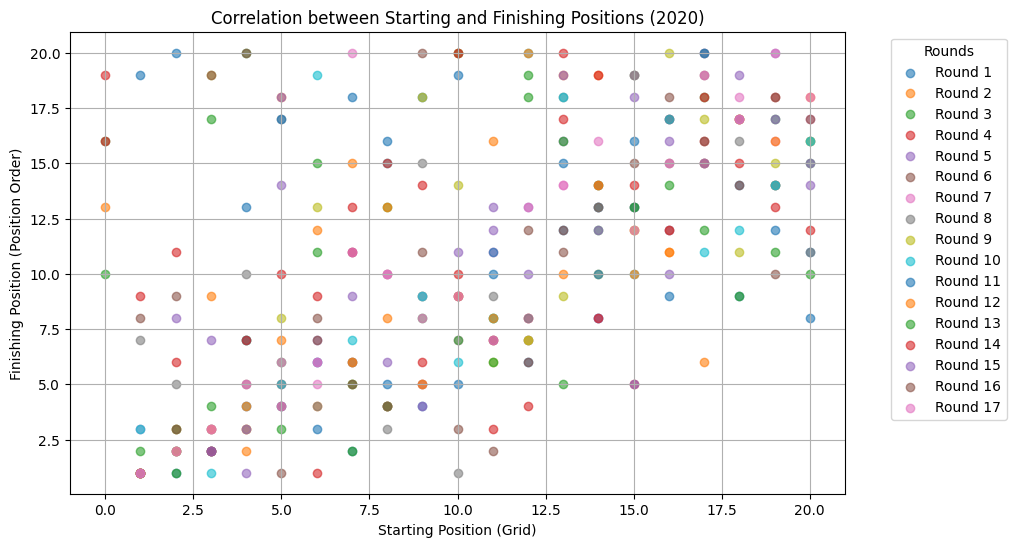

In [14]:
# Filtrer les données pour une année spécifique
data_2020 = data_filtered[data_filtered['year'] == 2020]

# Afficher le graphique
plt.figure(figsize=(10, 6))
for rnd in sorted(data_2020['round'].unique()):
    round_data = data_2020[data_2020['round'] == rnd]
    plt.scatter(round_data['grid'], round_data['positionOrder'], label=f"Round {rnd}", alpha=0.6)

plt.title('Correlation between Starting and Finishing Positions (2020)')
plt.xlabel('Starting Position (Grid)')
plt.ylabel('Finishing Position (Position Order)')
plt.legend(title='Rounds', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


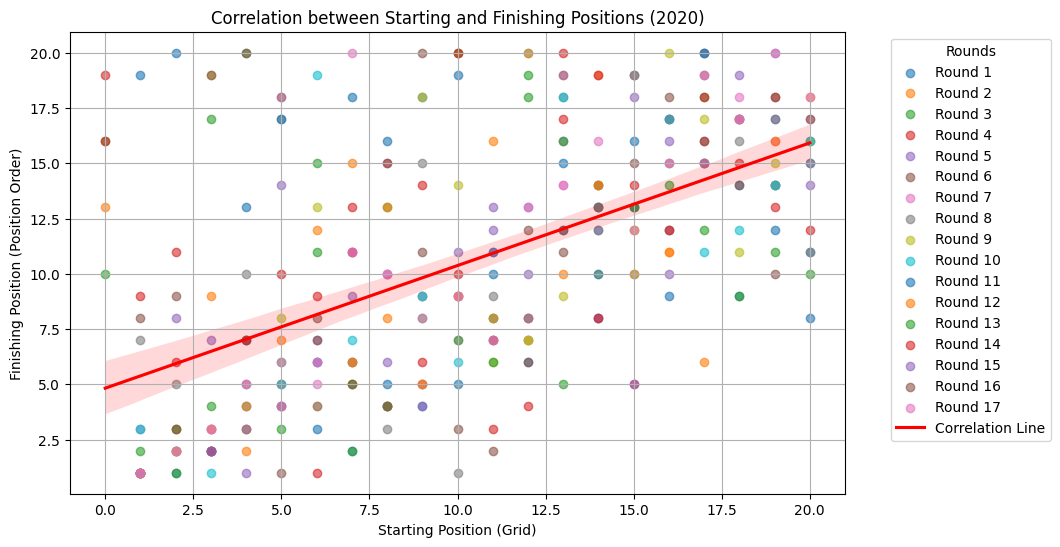

In [15]:
# Filtrer les données pour une année spécifique
data_2020 = data_filtered[data_filtered['year'] == 2020]

# Créer le graphique avec les points pour chaque round
plt.figure(figsize=(10, 6))
for rnd in sorted(data_2020['round'].unique()):
    round_data = data_2020[data_2020['round'] == rnd]
    plt.scatter(round_data['grid'], round_data['positionOrder'], label=f"Round {rnd}", alpha=0.6)

# Ajouter une ligne de corrélation
sns.regplot(
    data=data_2020,
    x='grid',
    y='positionOrder',
    scatter=False,  # Pas besoin de scatter ici (déjà géré)
    color='red',
    label='Correlation Line'
)

# Ajouter des titres et des labels
plt.title('Correlation between Starting and Finishing Positions (2020)')
plt.xlabel('Starting Position (Grid)')
plt.ylabel('Finishing Position (Position Order)')
plt.legend(title='Rounds', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Afficher le graphique
plt.show()


#### 3.2. Graphique de la moyenne des positions finales par position de départ
Moyenne des positions finales pour toutes les années (2018-2023)

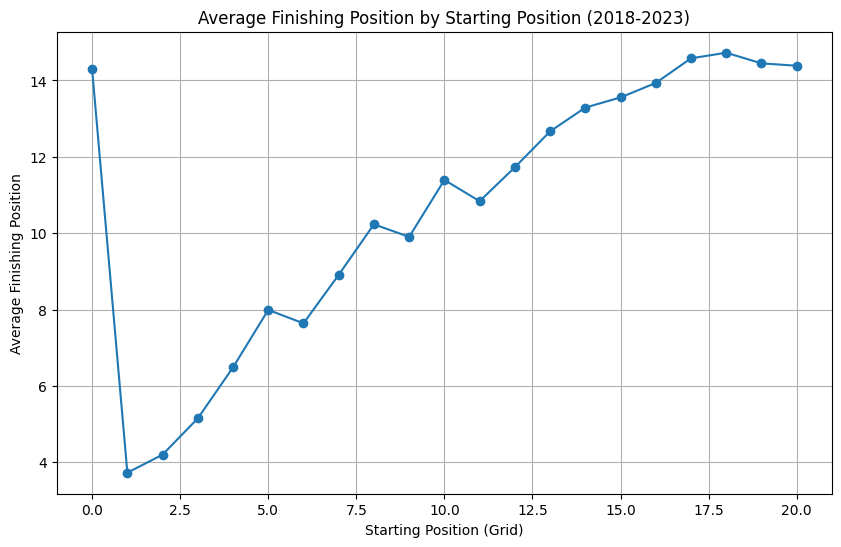

In [16]:
# Calculer la moyenne des positions finales par position de départ
avg_positions = data_filtered.groupby('grid')['positionOrder'].mean()

# Afficher le graphique
plt.figure(figsize=(10, 6))
plt.plot(avg_positions.index, avg_positions.values, marker='o')
plt.title('Average Finishing Position by Starting Position (2018-2023)')
plt.xlabel('Starting Position (Grid)')
plt.ylabel('Average Finishing Position')
plt.grid(True)
plt.show()


#### 3.3. Distribution des gains ou pertes de positions
Distribution des gains et pertes de positions (2018-2023)

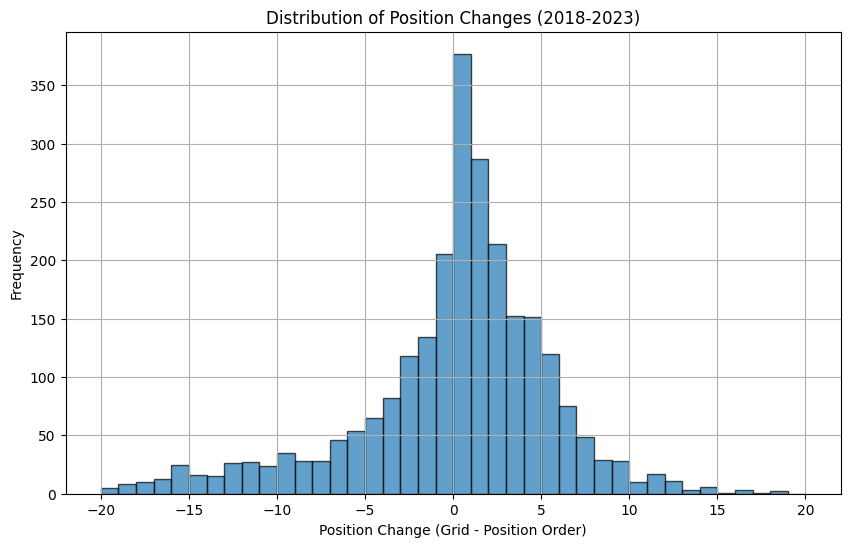

In [17]:
# Calculer les gains ou pertes de positions
data_filtered['gain_loss'] = data_filtered['grid'] - data_filtered['positionOrder']

# Afficher le graphique
plt.figure(figsize=(10, 6))
plt.hist(data_filtered['gain_loss'], bins=range(-20, 21), edgecolor='black', alpha=0.7)
plt.title('Distribution of Position Changes (2018-2023)')
plt.xlabel('Position Change (Grid - Position Order)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Ce graphe représente la distribution des changements de positions (gains ou pertes) des pilotes entre leur position de départ (grid) et leur position finale (positionOrder) sur la période 2018-2023.

### Analyse :
1. **Pic central (0)** : 
   - Le pic au centre indique que la majorité des pilotes finissent à peu près à la même position où ils ont commencé. Autrement dit, les positions de départ ont une forte influence sur les résultats.

2. **Gains de position (barres positives, >0)** :
   - Les barres situées à droite de 0 représentent les pilotes qui ont amélioré leur position par rapport à leur départ. Ces gains peuvent être liés à une meilleure performance, des stratégies efficaces, ou des incidents ayant affecté d'autres pilotes.

3. **Pertes de position (barres négatives, <0)** :
   - Les barres situées à gauche de 0 représentent les pilotes qui ont perdu des positions. Cela pourrait être dû à des accidents, des erreurs de pilotage, ou des problèmes mécaniques.

4. **Distribution asymétrique** :
   - La distribution montre une légère asymétrie vers la droite, suggérant qu’il est plus fréquent pour un pilote de gagner des positions que d’en perdre beaucoup.
   - Cela peut être attribué à des pilotes partant des dernières positions (grille basse) qui profitent d'une grille moins compétitive pour remonter.

5. **Extrêmes** :
   - Sur la gauche, quelques cas montrent des pertes importantes (jusqu’à -20), probablement dues à des abandons.
   - Sur la droite, les gains élevés (jusqu’à +20) représentent des performances exceptionnelles ou des remontées spectaculaires depuis l'arrière de la grille.

### Conclusion :
- Ce graphe met en évidence une tendance générale où les positions de départ jouent un rôle important, mais des gains significatifs sont possibles, surtout pour les pilotes partant en milieu ou en fond de grille. Les pertes importantes sont relativement rares, ce qui montre une certaine stabilité dans les positions après le départ.

C:\Users\JKQHD\AppData\Local\Temp\ipykernel_24748\3653098850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020['gain_loss'] = data_2020['grid'] - data_2020['positionOrder']


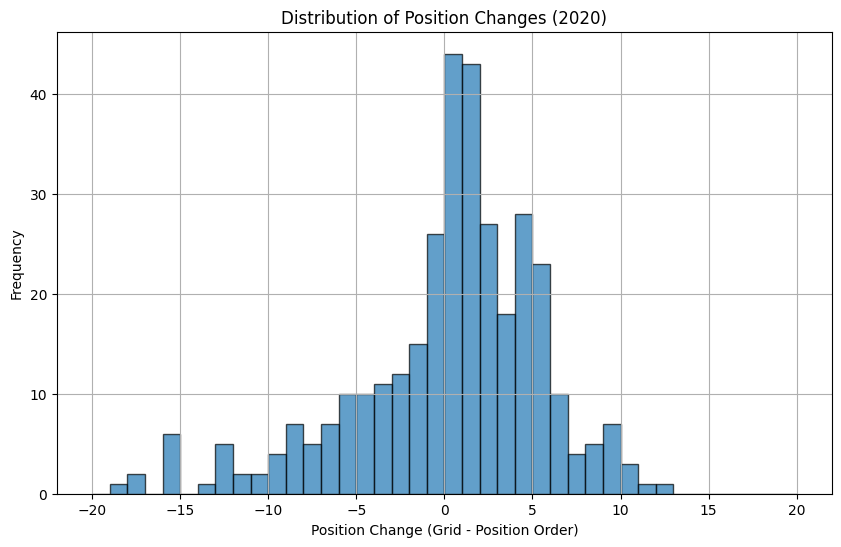

In [25]:
data_2020 = data_filtered[data_filtered['year'] == 2020]

# Calculer les gains ou pertes de positions
data_2020['gain_loss'] = data_2020['grid'] - data_2020['positionOrder']

# Afficher le graphique
plt.figure(figsize=(10, 6))
plt.hist(data_2020['gain_loss'], bins=range(-20, 21), edgecolor='black', alpha=0.7)
plt.title('Distribution of Position Changes (2020)')
plt.xlabel('Position Change (Grid - Position Order)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [19]:
# Grouping start positions into categories for the boxplot
def group_start_position(position):
    if position <= 3:
        return '1-3'
    elif position <= 6:
        return '4-6'
    elif position <= 10:
        return '7-10'
    elif position <= 15:
        return '11-15'
    elif position <= 20:
        return '16-20'
    else:
        return '21+'

data_filtered['grid_group'] = data_filtered['grid'].apply(group_start_position)

#### 3.4. Boxplot: Position finale en fonction de la position de départ

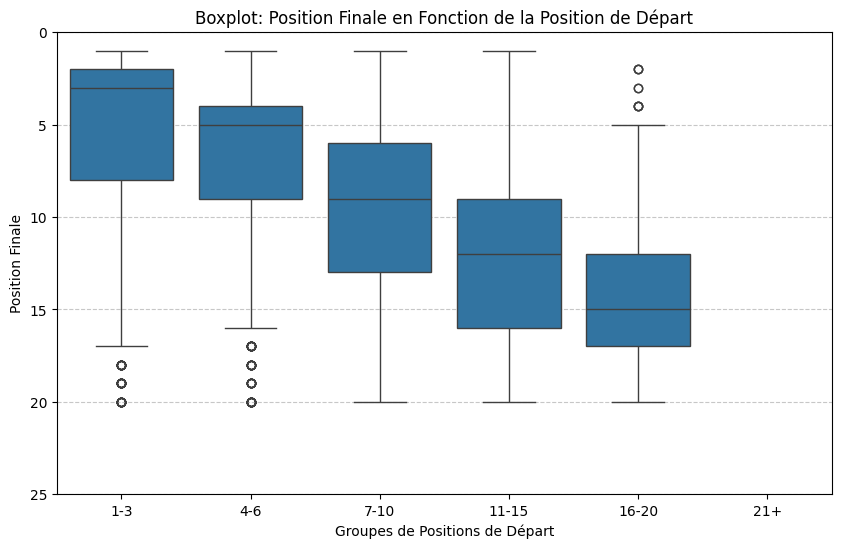

In [20]:
### 1. Boxplot: Position finale en fonction de la position de départ
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_filtered, x='grid_group', y='positionOrder', order=['1-3', '4-6', '7-10', '11-15', '16-20', '21+'])
plt.title('Boxplot: Position Finale en Fonction de la Position de Départ')
plt.xlabel('Groupes de Positions de Départ')
plt.ylabel('Position Finale')
plt.ylim(0, 25)
plt.gca().invert_yaxis()  # Invert y-axis for better visualization of rankings (lower is better)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 3.5. Courbe de Probabilité de finir dans le top 3 ou top 10

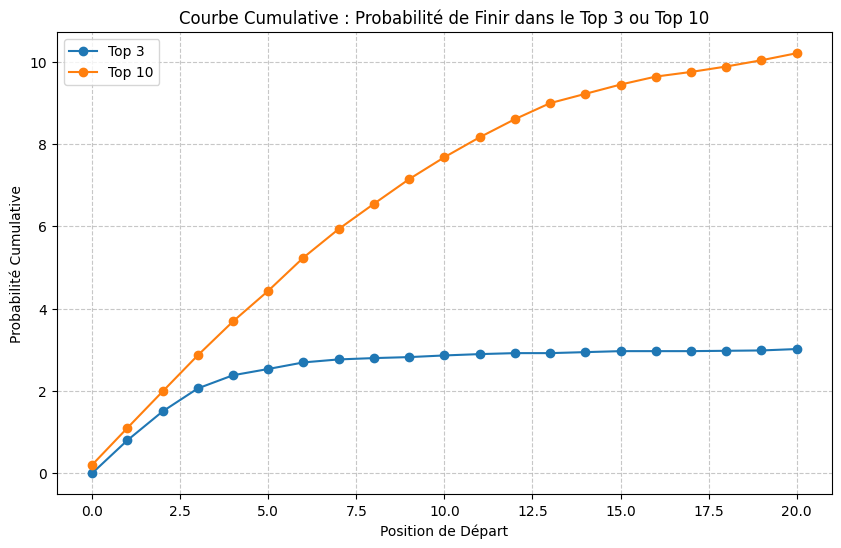

In [21]:
### 2. Courbe cumulative : Probabilité de finir dans le top 3 ou top 10
data_filtered['top_3'] = data_filtered['positionOrder'] <= 3
data_filtered['top_10'] = data_filtered['positionOrder'] <= 10

cumulative_top_3 = data_filtered.groupby('grid')['top_3'].mean().cumsum()
cumulative_top_10 = data_filtered.groupby('grid')['top_10'].mean().cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_top_3.index, cumulative_top_3, label='Top 3', marker='o')
plt.plot(cumulative_top_10.index, cumulative_top_10, label='Top 10', marker='o')
plt.title('Courbe Cumulative : Probabilité de Finir dans le Top 3 ou Top 10')
plt.xlabel('Position de Départ')
plt.ylabel('Probabilité Cumulative')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


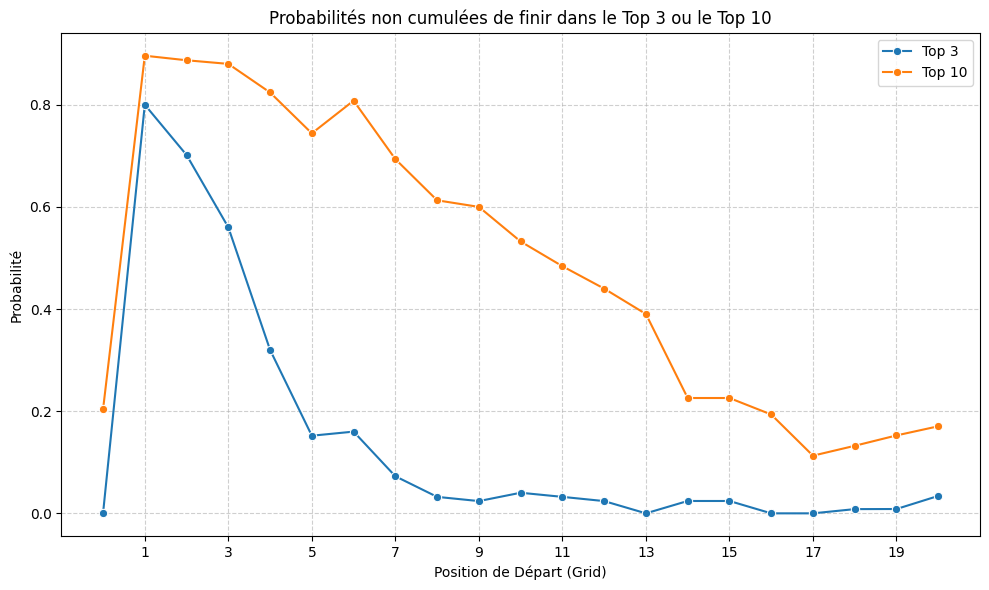

In [22]:
# Supposons que les données fusionnées soient déjà disponibles dans un DataFrame nommé `data`.
# Calcul des probabilités pour le top 3 et le top 10

def calculate_probabilities(data, top_n):
    """
    Calcule la probabilité pour chaque position de départ de finir dans le top_n.
    """
    probabilities = (
        data.assign(in_top=lambda df: df["positionOrder"] <= top_n)
        .groupby("grid")
        .agg(total_races=("positionOrder", "count"), in_top_count=("in_top", "sum"))
        .assign(probability=lambda df: df["in_top_count"] / df["total_races"])
    )
    return probabilities.reset_index()

# Calcul des probabilités pour le top 3 et le top 10
probabilities_top3 = calculate_probabilities(data_filtered, top_n=3)
probabilities_top10 = calculate_probabilities(data_filtered, top_n=10)

# Création de la figure pour les probabilités non cumulées
plt.figure(figsize=(10, 6))
sns.lineplot(data=probabilities_top3, x="grid", y="probability", marker="o", label="Top 3")
sns.lineplot(data=probabilities_top10, x="grid", y="probability", marker="o", label="Top 10")

# Configuration du graphique
plt.title("Probabilités non cumulées de finir dans le Top 3 ou le Top 10")
plt.xlabel("Position de Départ (Grid)")
plt.ylabel("Probabilité")
plt.xticks(range(1, probabilities_top3["grid"].max() + 1, 2))
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Affichage
plt.show()


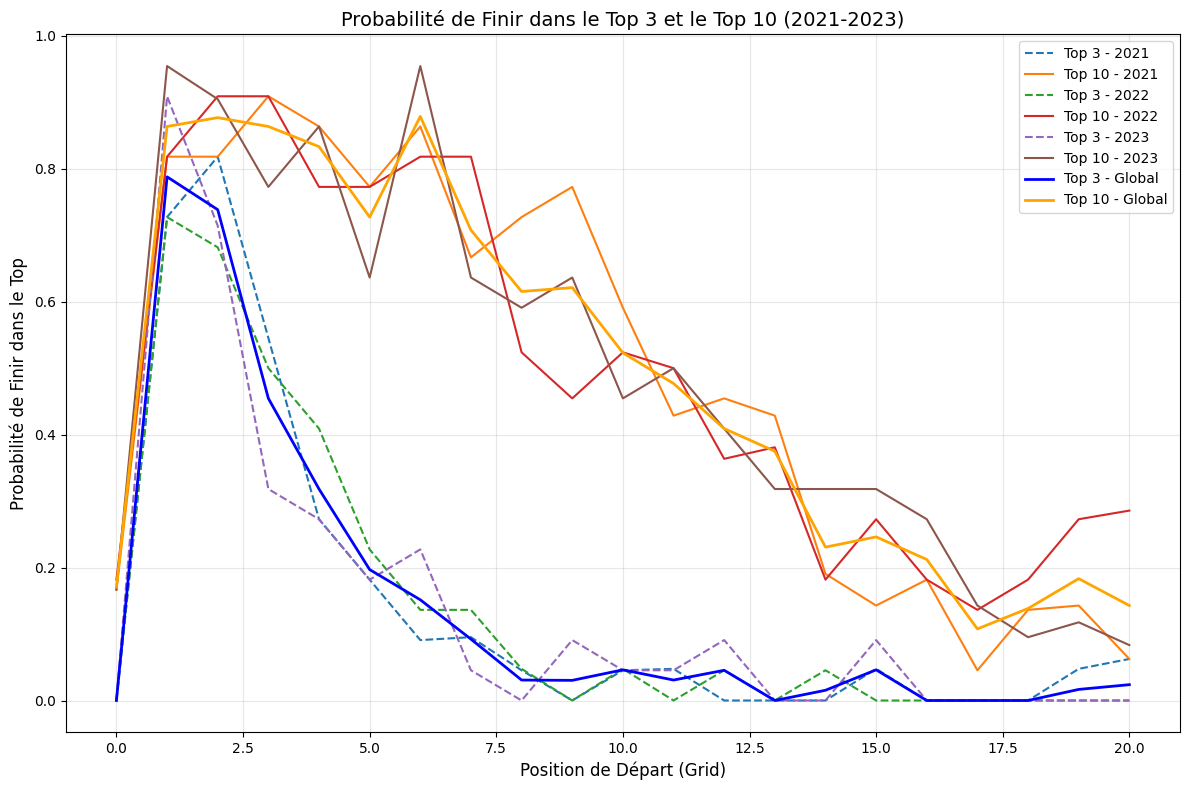

In [23]:
# Exemple: Supposons que le dataframe s'appelle "data_filtered"
# Assurez-vous que "data_filtered" contient bien les colonnes 'year', 'grid', 'positionOrder'.

# Liste des années d'intérêt
years_of_interest = [2021, 2022, 2023]

def calculate_probabilities(df, top_n):
    """Calculer les probabilités de finir dans le top_n pour chaque position de départ."""
    probabilities = []
    for grid_position in sorted(df['grid'].unique()):
        total_races = len(df[df['grid'] == grid_position])
        top_n_finishes = len(df[(df['grid'] == grid_position) & (df['positionOrder'] <= top_n)])
        probability = top_n_finishes / total_races if total_races > 0 else 0
        probabilities.append((grid_position, probability))
    return probabilities

# Préparation de la figure
plt.figure(figsize=(12, 8))

# Calcul et tracé des probabilités pour chaque année
for year in years_of_interest:
    yearly_data = data_filtered[data_filtered['year'] == year]
    probabilities_top3 = calculate_probabilities(yearly_data, top_n=3)
    probabilities_top10 = calculate_probabilities(yearly_data, top_n=10)

    # Conversion en DataFrame pour faciliter le tracé
    df_top3 = pd.DataFrame(probabilities_top3, columns=['grid', 'probability'])
    df_top10 = pd.DataFrame(probabilities_top10, columns=['grid', 'probability'])

    # Tracé pour le top 3
    plt.plot(df_top3['grid'], df_top3['probability'], label=f'Top 3 - {year}', linestyle='--')

    # Tracé pour le top 10
    plt.plot(df_top10['grid'], df_top10['probability'], label=f'Top 10 - {year}', linestyle='-')

# Calcul et tracé des probabilités globales (toutes années confondues)
global_data = data_filtered[data_filtered['year'].isin(years_of_interest)]
global_probabilities_top3 = calculate_probabilities(global_data, top_n=3)
global_probabilities_top10 = calculate_probabilities(global_data, top_n=10)

df_global_top3 = pd.DataFrame(global_probabilities_top3, columns=['grid', 'probability'])
df_global_top10 = pd.DataFrame(global_probabilities_top10, columns=['grid', 'probability'])

plt.plot(df_global_top3['grid'], df_global_top3['probability'], label='Top 3 - Global', color='blue', linewidth=2)
plt.plot(df_global_top10['grid'], df_global_top10['probability'], label='Top 10 - Global', color='orange', linewidth=2)

# Configuration des axes et de la légende
plt.xlabel('Position de Départ (Grid)', fontsize=12)
plt.ylabel('Probabilité de Finir dans le Top', fontsize=12)
plt.title('Probabilité de Finir dans le Top 3 et le Top 10 (2021-2023)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### 3.6. Heatmap : Position de Départ vs Position Finale

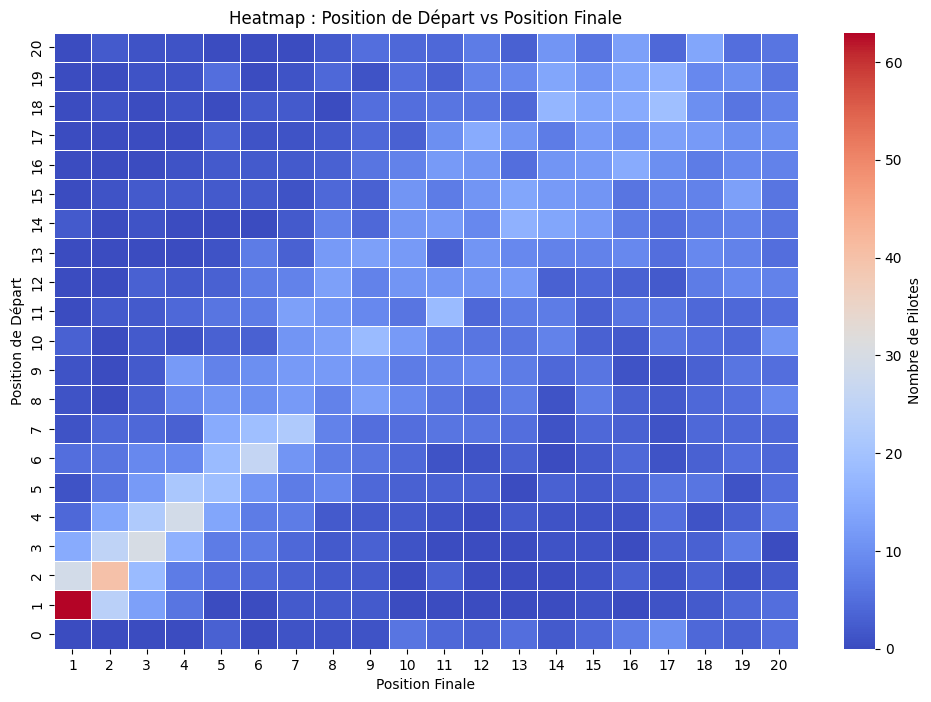

In [24]:
### 3. Heatmap : Position de Départ vs Position Finale
heatmap_data = data_filtered.groupby(['grid', 'positionOrder']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, cbar_kws={'label': 'Nombre de Pilotes'}, linewidths=0.5)
plt.title('Heatmap : Position de Départ vs Position Finale')
plt.xlabel('Position Finale')
plt.ylabel('Position de Départ')
plt.gca().invert_yaxis()  # Invert y-axis for consistency with ranking (lower is better)
plt.show()